## 1. Visualise probing F1s

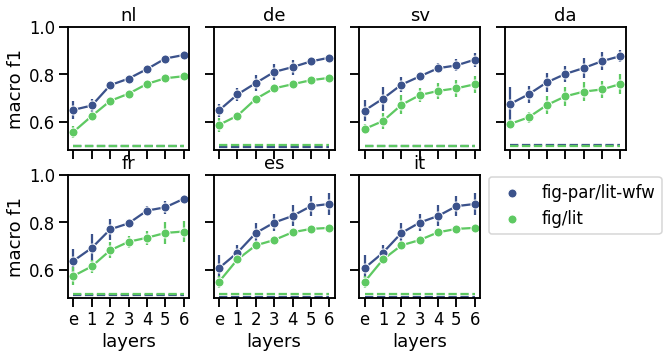

In [1]:
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

languages = ["nl", "de", "sv", "da", "fr",  "es", "es"]

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = \
    plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

colours = sns.color_palette("viridis", 3)

for i in range(7):
    for setup, average_pie in [("hidden", False)]:
        if setup == "attention":
            #plt.figure(figsize=(2.7, 3))
            layers = [0, 1, 2, 3, 4, 5]
            xticklabels = [1, 2, 3, 4, 5, 6]
        else:
            #plt.figure(figsize=(3, 3))
            layers = [0, 1, 2, 3, 4, 5, 6]
            xticklabels = ["e", 1, 2, 3, 4, 5, 6]

        data = pickle.load(open(f"data/{languages[i]}/f1s_setup={setup}_target=both_average={average_pie}.pickle", 'rb'))
        sns.scatterplot(x=layers, y=[np.mean(data[l]["f1_test"]) for l in layers],
                             color=colours[0], linewidth=1, label="fig-par/lit-wfw", ax=axes[i])
        axes[i].errorbar(layers, [np.mean(data[l]["f1_test"]) for l in layers],
                     yerr=[np.std(data[l]["f1_test"]) for l in layers], color=colours[0], zorder=-1)
        sns.lineplot(x=layers, y=[np.mean([np.mean(data[l]["f1_baseline"]) for l in layers])] * (7 \
                                  if setup == "hidden" else 6),
                     color=colours[0], alpha=1, zorder=-1, linestyle='--', ax=axes[i])

        data = pickle.load(open(f"data/{languages[i]}/f1s_setup={setup}_target=magpie_average={average_pie}.pickle", 'rb'))
        ax = sns.scatterplot(x=layers, y=[np.mean(data[l]["f1_test"]) for l in layers],
                             color=colours[2], linewidth=1, label="fig/lit", ax=axes[i])
        axes[i].errorbar(layers, [np.mean(data[l]["f1_test"]) for l in layers],
                     yerr=[np.std(data[l]["f1_test"]) for l in layers], color=colours[2], zorder=-1)
        sns.lineplot(x=layers, y=[np.mean([np.mean(data[l]["f1_baseline"]) for l in layers])] * (7 \
                                  if setup == "hidden" else 6),
                     color=colours[2], alpha=1, zorder=-1, linestyle='--', ax=axes[i])

        ax.set_xticks(layers)
        ax.set_xticklabels(xticklabels)
        if i != 6:
            axes[i].legend([], [], frameon=False)
        else:
            axes[i].legend(bbox_to_anchor=(1, 1.05))

        axes[i].set_ylabel("macro f1")
        axes[i].set_xlabel("layers")
        if i == 6:
            axes[i].set_title("it")
        else:
            axes[i].set_title(languages[i])

    plt.ylim(0.48, 1)
    plt.legend([],[],frameon=False)


ax8.clear()
ax8.axis("off")
ax8.set_visible(False)
ax8.remove()
plt.xticks(layers, xticklabels)

    
plt.savefig(f"figures/languages_probing_setup={setup}_average={average_pie}.pdf", bbox_inches="tight")
plt.show()

## 2. Visualise attention from before and after intervention

In [ ]:
import pickle
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

for language in ["nl", "de", "sv", "da", "fr", "it", "es"]:
    attention = pickle.load(open(f"data/{language}/attention_{language}.pickle", 'rb'))

    x, y, hue = [], [], []
    difference = []
    for before, after, noun_pie_indices, context_pie_indices, all_pie_indices, all_context_indices in attention:
        before = torch.FloatTensor(before)
        after = torch.FloatTensor(after)

        all_pie_indices = [x for x in all_pie_indices if x not in noun_pie_indices]
        before = torch.index_select(before, dim=-2, index=torch.LongTensor(all_pie_indices))
        before = torch.mean(torch.index_select(before, dim=-1, index=torch.LongTensor(noun_pie_indices)))

        after = torch.index_select(after, dim=-2, index=torch.LongTensor(all_pie_indices))
        after = torch.mean(torch.index_select(after, dim=-1, index=torch.LongTensor(noun_pie_indices)))
        difference.append((after.item() - before.item()) / before.item() * 100)

    x.extend([0 for _ in difference])
    y.extend(difference)
    hue.extend(["pie-pie" for _ in difference])

    difference = []
    for before, after, noun_pie_indices, noun_context_indices, all_pie_indices, all_context_indices in attention:
        before = torch.FloatTensor(before)
        after = torch.FloatTensor(after)

        all_pie_indices = [x for x in all_pie_indices if x not in noun_pie_indices]
        before = torch.index_select(before, dim=-2, index=torch.LongTensor(all_pie_indices))
        before = torch.mean(torch.index_select(before, dim=-1, index=torch.LongTensor(noun_context_indices)))

        after = torch.index_select(after, dim=-2, index=torch.LongTensor(all_pie_indices))
        after = torch.mean(torch.index_select(after, dim=-1, index=torch.LongTensor(noun_context_indices)))
        difference.append((after.item() - before.item())/before.item() * 100)

    x.extend([0 for _ in difference])
    y.extend(difference)
    hue.extend(["pie-con" for _ in difference])

    difference = []
    for before, after, noun_pie_indices, noun_context_indices, all_pie_indices, all_context_indices in attention:
        before = torch.FloatTensor(before)
        after = torch.FloatTensor(after)

        all_pie_indices = [x for x in all_pie_indices if x not in noun_pie_indices]
        before = torch.index_select(before, dim=-2, index=torch.LongTensor(all_context_indices))
        before = torch.mean(torch.index_select(before, dim=-1, index=torch.LongTensor(noun_pie_indices)))

        after = torch.index_select(after, dim=-2, index=torch.LongTensor(all_context_indices))
        after = torch.mean(torch.index_select(after, dim=-1, index=torch.LongTensor(noun_pie_indices)))
        difference.append((after.item() - before.item()) / before.item() * 100)

    x.extend([0 for _ in difference])
    y.extend(difference)
    hue.extend(["con-pie" for _ in difference])

    plt.figure(figsize=(2, 3))
    ax = sns.boxplot(x=x, y=y, hue=hue, palette="viridis", fliersize=0)
    plt.ylabel("change (%)")
    plt.ylim(-60, 50)
    plt.yticks([-50, -25, 0, 25, 50])
    plt.xlim(-0.5, 0.5)
    ax = sns.lineplot(x=[-1, 1], y=[0, 0], color="black", linestyle="--", zorder=-1)
    plt.legend(bbox_to_anchor=(1, 0.5), frameon=False)
    ax.set_xticks([])
    #plt.ylabel("")        

    plt.savefig(f"figures/{language}/inlp_attention.pdf", bbox_inches="tight")
    plt.show()